In [515]:
pip install yfinance pandas_datareader matplotlib 

In [566]:
from pandas_datareader import data as pdr
import datetime
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import requests
yf.pdr_override() # <== that's all it takes :-)

## MEP

In [580]:
#https://www.rava.com/perfil/DOLAR%20MEP

In [562]:
df_mep = pd.read_csv("MEP.csv")
df_mep.rename(columns={"fecha": "Date", "cierre": "mep"},inplace=True)
df_mep.index = pd.to_datetime(df_mep["Date"])
df_mep = df_mep[["mep"]]
df_mep = df_mep.query("Date >= '2022-01-01' and Date <= '2022-08-01'")
df_mep = df_mep.resample("D").ffill()
df_mep["mep_aumento_acum"] = (1 + df_mep["mep"].pct_change()).cumprod() - 1


## Inflacion

In [581]:
#https://datosgobar.github.io/series-tiempo-ar-call-generator/
data_inflacion = "https://apis.datos.gob.ar/series/api/series?ids=101.1_I2NG_2016_M_22"
raw_inflacion = {"data": [["2022-01-01", 593.4219], ["2022-02-01", 620.5007], ["2022-03-01", 661.8688], ["2022-04-01", 702.829], ["2022-05-01", 736.3637], ["2022-06-01", 776.6701], ["2022-07-01", 833.8894], ["2022-08-01", 891.851]], "count": 8, "meta": [{"frequency": "month", "start_date": "2022-01-01", "end_date": "2022-08-01"}, {"catalog": {"title": "Datos Programaci\u00f3n Macroecon\u00f3mica"}, "dataset": {"title": "\u00cdndice de Precios al Consumidor GBA (IPC-GBA). Base diciembre 2016.", "description": "\u00cdndice de Precios al Consumidor del Gran Buenos Aires. Apertura por cap\u00edtulos. Base diciembre 2016.", "issued": "2017-09-28", "source": "Instituto Nacional de Estad\u00edstica y Censos (INDEC)"}, "distribution": {"title": "\u00cdndice de Precios al Consumidor, por cap\u00edtulos. Base  diciembre 2016. Valores mensuales", "downloadURL": "https://infra.datos.gob.ar/catalog/sspm/dataset/101/distribution/101.1/download/indice-precios-al-consumidor-apertura-por-capitulos-base-diembre-2016-mensual.csv"}, "field": {"description": "IPC-GBA. Nivel General. Base abr 2016. Mensual", "id": "101.1_I2NG_2016_M_22", "units": "\u00cdndice Dic-2016=100", "representation_mode": "value", "representation_mode_units": "\u00cdndice Dic-2016=100"}}], "params": {"ids": "101.1_I2NG_2016_M_22", "collapse": "month", "start_date": "2022-01-01", "end_date": "2022-09-19", "format": "json", "identifiers": [{"id": "101.1_I2NG_2016_M_22", "distribution": "101.1", "dataset": "101"}]}}
df_inflacion  = pd.DataFrame(raw_inflacion["data"], columns =["Date", "IPC"])
df_inflacion.index =  pd.to_datetime(df_inflacion["Date"])
df_inflacion = df_inflacion[["IPC"]]
df_inflacion = df_inflacion.resample("D").ffill()
df_inflacion["inflacion_acum"] = (1 + df_inflacion["IPC"].pct_change()).cumprod() - 1


## Inflacion vs Dolar Mep

<AxesSubplot: xlabel='Date'>

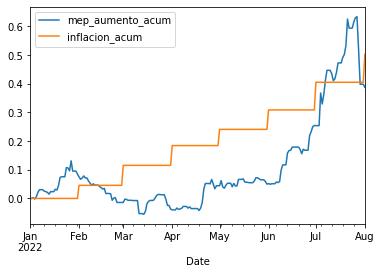

In [565]:
df_mep.join(df_inflacion)[["mep_aumento_acum", "inflacion_acum"]].plot()

In [798]:
#symbols = ['ARKK','DIA', 'EEM', 'EWZ','IWM', 'QQQ', 'SPY', 'XLE', 'XLF']
symbols = ["ALUA.BA", "BBAR.BA", "BMA.BA", "CEPU.BA", "COME.BA", "CRES.BA", "CVH.BA", "EDN.BA", "GGAL.BA", "MIRG.BA", "PAMP.BA", "SUPV.BA", "TECO2.BA", "TGNO4.BA", "TGSU2.BA", "TRAN.BA", "TXAR.BA", "VALO.BA", "YPFD.BA"]
weight_equal = [1/len(symbols) for _ in symbols ]
capital = 1000


In [799]:
today= datetime.datetime.now().strftime("%Y-%m-%d")
price_data = pdr.get_data_yahoo(symbols,
                               start = '2022-01-01',
                               end = "2022-08-01")

[*********************100%***********************]  19 of 19 completed


In [800]:
price_data = price_data[["Adj Close"]]


In [801]:
en_usd_df  = price_data["Adj Close"].divide(df_mep["mep"], axis="index")
en_usd_df.columns = pd.MultiIndex.from_product([["Adj Close USD"], list(en_usd_df.columns)])
price_data = pd.concat([price_data, en_usd_df], axis=1)

In [802]:
price_data = pd.concat([price_data, price_data.pct_change().rename(columns={'Adj Close USD':'pct_change'}, inplace=False)], axis=1)
price_data= price_data.dropna()

In [803]:
cum_return_df = (1 + price_data["pct_change"]).cumprod() - 1

In [804]:
cum_return_df.columns = pd.MultiIndex.from_product([["cum_return"], list(cum_return_df.columns)])

In [805]:
price_data = pd.concat([price_data, cum_return_df], axis=1)

In [806]:
valuated_df = ( capital  + (price_data["cum_return"] *  capital) ) * weight_equal
valuated_df.columns = pd.MultiIndex.from_product([["valuated"], list(valuated_df.columns)])
valuated_df.iloc[0] = [capital * w for w in  weight_equal]
price_data = pd.concat([price_data, valuated_df], axis=1)


In [807]:
final_result = price_data["valuated"].tail(1).sum(axis=1).item()
print(f"capital: $ {capital}")
print(f"final result: $ {final_result}")
print(f"final return: % {round(-(capital - (final_result) ) / capital * 100, 2)} in {len(price_data)} days")

capital: $ 1000
final result: $ 1049.4562471011493
final return: % 4.95 in 140 days


## Ajuste x inflacion

In [808]:
df_adjusted = pd.DataFrame(price_data["valuated"].sum(axis=1), columns=["valuation"]).join(df_inflacion)
df_adjusted["adjusted_valuation"] = df_adjusted["valuation"] * df_adjusted["inflacion_acum"]


<AxesSubplot: title={'center': 'total money trough time'}, xlabel='Date'>

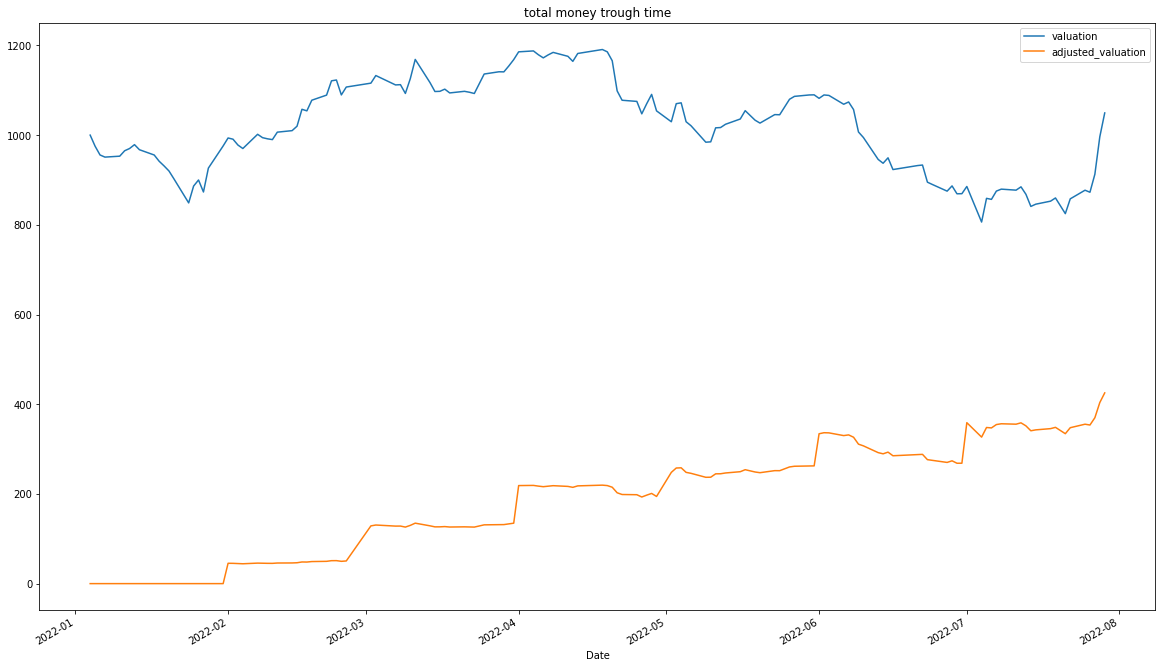

In [809]:
df_adjusted[["valuation", "adjusted_valuation"]].plot(figsize=(20,12), title="total money trough time")

<AxesSubplot: title={'center': 'money by symbol trough time'}, xlabel='Date'>

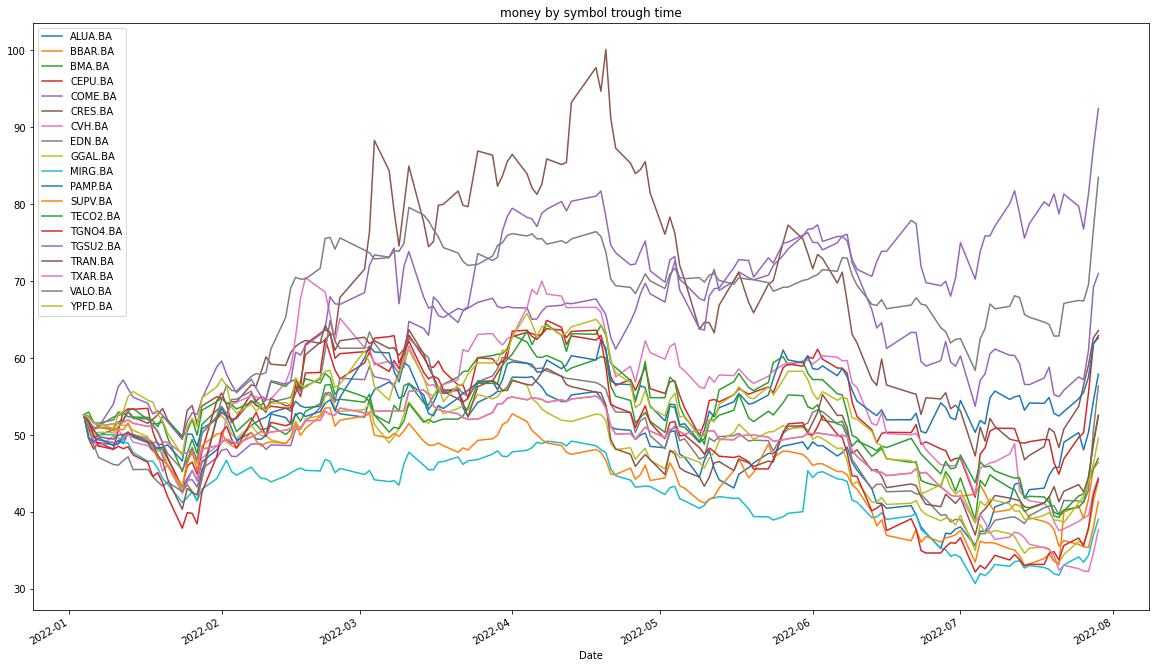

In [810]:
price_data["valuated"].plot(figsize=(20,12), title="money by symbol trough time")